<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-playground-series-s3-e12?scriptVersionId=162509346" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://www.kaggle.com/competitions/49200/images/header)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


# <span style="color: gold;">Playground Series - Season 3, Episode 12</span>
## <span style="color: orange;">Binary Classification with a Kidney Stone Prediction Dataset</span>

### <span style="color: #00BFFF;">Welcome to the 2023 edition of Kaggle's Playground Series!</span>
Thank you to everyone who participated in and contributed to Season 3 Playground Series so far!

With the same goal to give the Kaggle community a variety of fairly light-weight challenges that can be used to learn and sharpen skills in different aspects of machine learning and data science, we will continue launching the Tabular Tuesday in April every Tuesday 00:00 UTC, with each competition running for 2 weeks. Again, these will be fairly light-weight datasets that are synthetically generated from real-world data, and will provide an opportunity to quickly iterate through various model and feature engineering ideas, create visualizations, etc..

### <span style="color: #00BFFF;">Synthetically-Generated Datasets</span>
Using synthetic data for Playground competitions allows us to strike a balance between having real-world data (with named features) and ensuring test labels are not publicly available. This allows us to host competitions with more interesting datasets than in the past. While there are still challenges with synthetic data generation, the state-of-the-art is much better now than when we started the Tabular Playground Series two years ago, and that goal is to produce datasets that have far fewer artifacts. Please feel free to give us feedback on the datasets for the different competitions so that we can continue to improve!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

#### <span style="color: #00BFFF">Submission File</span>
For each id in the test set, you must predict the probability of target (likelihood of the presence of a kidney stone). The file should contain a header and have the following format:

```Python
id,target
414,0.5
415,0.1
416,0.9
etc.
```

# <span style="color: #00BFFF;">1 - Import the necessary libraries #

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# <span style="color: #00BFFF;">2 - Open training and test data #

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
train.head(5)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


# <span style="color: #00BFFF;">3 - Display a list of features #

In [4]:
train.columns.tolist()

['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']

# <span style="color: #00BFFF;">4 - Display dataset size

In [5]:
train.shape

(414, 8)

# <span style="color: #00BFFF;">5 - Display descriptive statistics of train data #

In [6]:
train.describe()

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [7]:
# 5a - Display descriptive statistics of test data
test.describe()

,id,gravity,ph,osmo,cond,urea,calc
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,551.500000,1.018330,5.939312,654.891304,21.886594,280.985507,4.076848
std,79.818544,0.006569,0.607143,236.361932,7.346069,134.877856,3.088524
min,414.000000,1.005000,4.900000,187.000000,5.100000,64.000000,0.170000
25%,482.750000,1.014000,5.530000,456.000000,17.400000,168.500000,1.527500
50%,551.500000,1.019000,5.730000,658.000000,23.600000,282.000000,3.230000
75%,620.250000,1.023250,6.210000,843.250000,27.600000,385.000000,5.540000
max,689.000000,1.034000,7.940000,1236.000000,38.000000,620.000000,14.340000


# <span style="color: #00BFFF;">6 - Check the number of gaps for each feature in train #

In [8]:
train.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [9]:
# 6a - Check the number of gaps for each feature in test
test.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
dtype: int64

# <span style="color: #00BFFF;">7 - Look at the data type of the training set #

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


# <span style="color: #00BFFF;">8 - Build a heat map of correlations (sns.heatmap produced anomalous errors) #

In [11]:
correlation = train.corr()
correlation.style.background_gradient(cmap='coolwarm')

,id,gravity,ph,osmo,cond,urea,calc,target
id,1.000000,-0.004775,-0.086619,0.008030,0.032843,-0.023822,0.032360,0.018222
gravity,-0.004775,1.000000,-0.290349,0.692317,0.470433,0.631710,0.494304,0.282577
ph,-0.086619,-0.290349,1.000000,-0.309495,-0.190185,-0.279749,-0.214402,-0.094983
osmo,0.008030,0.692317,-0.309495,1.000000,0.708480,0.809880,0.472114,0.244770
cond,0.032843,0.470433,-0.190185,0.708480,1.000000,0.499109,0.330609,0.172224
urea,-0.023822,0.631710,-0.279749,0.809880,0.499109,1.000000,0.489879,0.265211
calc,0.032360,0.494304,-0.214402,0.472114,0.330609,0.489879,1.000000,0.467439
target,0.018222,0.282577,-0.094983,0.244770,0.172224,0.265211,0.467439,1.000000


# <span style="color: #00BFFF;">9 - Remove 'osmo' feature to reduce correlation to avoid multicolinearity #

In [12]:
correlation = train.drop(columns='osmo', axis=1).corr()
train.drop(columns='osmo', axis=1, inplace=True)
correlation.style.background_gradient(cmap='summer')

,id,gravity,ph,cond,urea,calc,target
id,1.000000,-0.004775,-0.086619,0.032843,-0.023822,0.032360,0.018222
gravity,-0.004775,1.000000,-0.290349,0.470433,0.631710,0.494304,0.282577
ph,-0.086619,-0.290349,1.000000,-0.190185,-0.279749,-0.214402,-0.094983
cond,0.032843,0.470433,-0.190185,1.000000,0.499109,0.330609,0.172224
urea,-0.023822,0.631710,-0.279749,0.499109,1.000000,0.489879,0.265211
calc,0.032360,0.494304,-0.214402,0.330609,0.489879,1.000000,0.467439
target,0.018222,0.282577,-0.094983,0.172224,0.265211,0.467439,1.000000


# <span style="color: #00BFFF;">10 - Set up visualization #

In [13]:
sns.set(rc={'figure.figsize': (18, 12)})

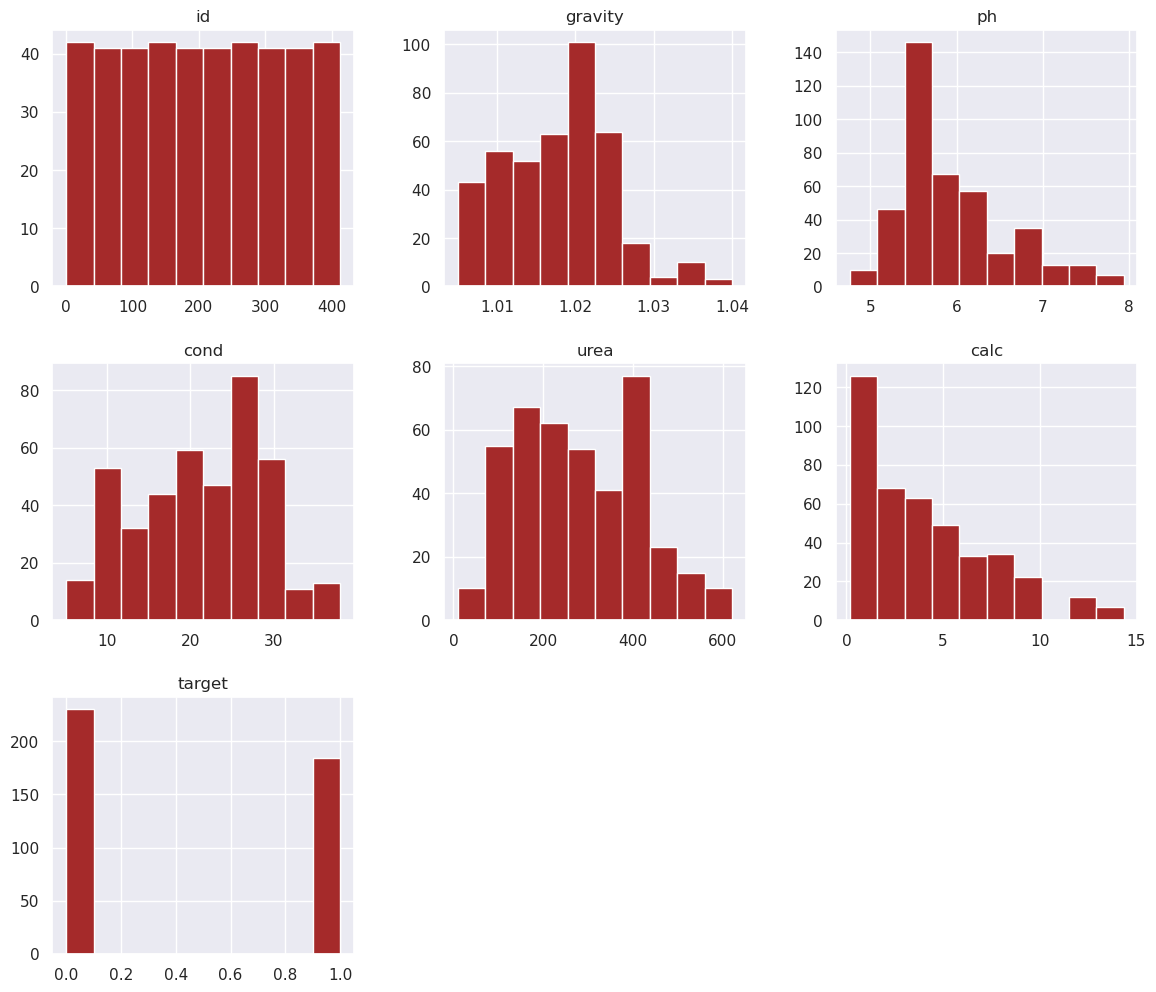

In [14]:
train.hist(figsize=(14, 12), color='brown');

# <span style="color: #00BFFF;">11 - Let's look at the distributions of features #

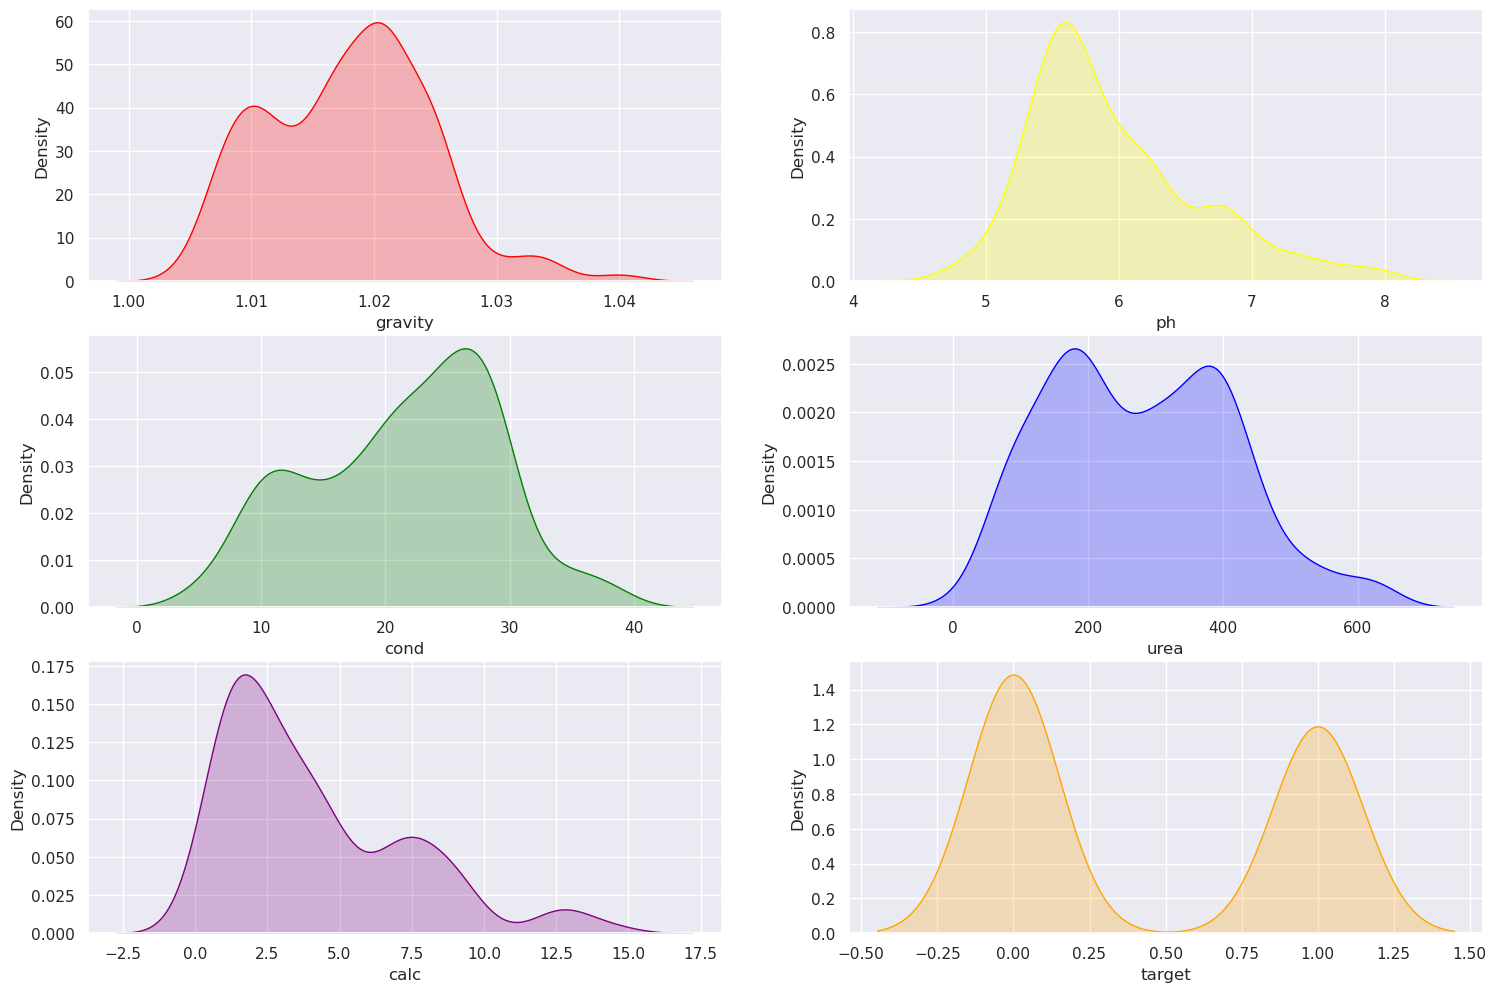

In [15]:
plt.subplot(3, 2, 1)
sns.kdeplot(data=train['gravity'], color='red', fill=True)

plt.subplot(3, 2, 2)
sns.kdeplot(data=train['ph'], color='yellow', fill=True);

plt.subplot(3, 2, 3)
sns.kdeplot(data=train['cond'], color='green', fill=True);

plt.subplot(3, 2, 4)
sns.kdeplot(data=train['urea'], color='blue', fill=True);

plt.subplot(3, 2, 5)
sns.kdeplot(data=train['calc'], color='purple', fill=True);

plt.subplot(3, 2, 6)
sns.kdeplot(data=train['target'], color='orange', fill=True);

In [16]:
# 11a Counts unique target values
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

# <span style="color: #00BFFF;">12 - Split the training dataset into X and y #

In [17]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']

# <span style="color: #00BFFF;">13 - Split the training data into training and validation (test) #

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

# <span style="color: #00BFFF;">14 - Standardize data #

In [19]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
test_data = test.drop(columns=['id', 'osmo'], axis=1)

# <span style="color: #00BFFF;">15 - Train the CatBoost Classifier model #

In [20]:
clf = CatBoostClassifier(max_depth=10)
clf.fit(X_train_std, y_train)

Learning rate set to 0.006425
0:	learn: 0.6903163	total: 60.8ms	remaining: 1m
1:	learn: 0.6869151	total: 66.1ms	remaining: 33s
2:	learn: 0.6840545	total: 70ms	remaining: 23.3s
3:	learn: 0.6806963	total: 73.7ms	remaining: 18.4s
4:	learn: 0.6773350	total: 77.1ms	remaining: 15.3s
5:	learn: 0.6757462	total: 77.6ms	remaining: 12.8s
6:	learn: 0.6727311	total: 80.5ms	remaining: 11.4s
7:	learn: 0.6701266	total: 83.8ms	remaining: 10.4s
8:	learn: 0.6672628	total: 86.7ms	remaining: 9.54s
9:	learn: 0.6641715	total: 89.8ms	remaining: 8.89s
10:	learn: 0.6610686	total: 92.9ms	remaining: 8.36s
11:	learn: 0.6583863	total: 96ms	remaining: 7.9s
12:	learn: 0.6554395	total: 99.3ms	remaining: 7.54s
13:	learn: 0.6531356	total: 103ms	remaining: 7.22s
14:	learn: 0.6505785	total: 106ms	remaining: 6.95s
15:	learn: 0.6480209	total: 109ms	remaining: 6.71s
16:	learn: 0.6450622	total: 114ms	remaining: 6.58s
17:	learn: 0.6419351	total: 118ms	remaining: 6.41s
18:	learn: 0.6394522	total: 121ms	remaining: 6.22s
19:	lear

# <span style="color: #00BFFF;">16 - Get a prediction on test data #

In [21]:
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)

# Get class labels
y_pred_test

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0])

# <span style="color: #00BFFF;">17 - Calculate Precision, Recall, F1 and ROC-AUC metrics #

In [22]:
# Precision for test data
print(f'precision: {precision_score(y_test, y_pred_test):.4f}\n')

# Precision for test data
print(f'recall: {recall_score(y_test, y_pred_test):.4f}\n')

# Precision for test data
print(f'F1: {f1_score(y_test, y_pred_test):.4f}\n')

# Precision for test data
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_test):.4f}')

precision: 0.6842

recall: 0.7027

F1: 0.6933

ROC-AUC: 0.7209


# <span style="color: #00BFFF;">18 - P.S. Metrics can also be obtained in another way #

In [23]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75        46
           1       0.68      0.70      0.69        37

    accuracy                           0.72        83
   macro avg       0.72      0.72      0.72        83
weighted avg       0.72      0.72      0.72        83



# <span style="color: #00BFFF;">19 - Creates ensemble from 15 models #

In [24]:
# Create instances of machine learning models and determine their hyperparameters
warnings.filterwarnings('ignore')

model1 = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)
model3 = SVC(kernel='linear', C=1)
model4 = SVC(kernel='rbf', C=0.1, gamma=0.1)
model5 = LogisticRegression(penalty='l2', C=1)
model6 = LogisticRegression(penalty='l2', C=0.1)
model7 = GaussianNB(var_smoothing=1e-09)
model8 = KNeighborsClassifier(n_neighbors=5)
model9 = KNeighborsClassifier(n_neighbors=10)
model10 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5)
model11 = MLPClassifier(hidden_layer_sizes=(50,50), solver='adam', activation='relu', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model12 = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, subsample=0.5, colsample_bytree=0.5)
model13 = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=10, subsample=0.8, colsample_bytree=0.8)
model14 = LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.05, n_estimators=100, max_depth=10, num_leaves=31)
model15 = LGBMClassifier(boosting_type='dart', objective='binary', learning_rate=0.01, n_estimators=200, max_depth=7, num_leaves=63)

models = [('dt1', model1), ('dt2', model2), ('svc1', model3), ('svc2', model4), ('lr1', model5), ('lr2', model6), 
          ('gnb', model7), ('knn1', model8), ('knn2', model9), ('rf', model10), ('mlp', model11), ('xgb1', model12),
          ('xgb2', model13), ('lgbm1', model14), ('lgbm2', model15)]

ensemble = VotingClassifier(models)

# train the ensemble on the training data
ensemble.fit(X_train, y_train)
predict = ensemble.predict(test_data)
predict

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1])

# <span style="color: #00BFFF;">20 - Creates ensemble from 20 models #

In [25]:
# Create instances of machine learning models and determine their hyperparameters
warnings.filterwarnings('ignore')

model1 = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=5)
model2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10)
model3 = SVC(kernel='linear', C=1)
model4 = SVC(kernel='rbf', C=0.1, gamma=0.1)
model5 = LogisticRegression(penalty='l2', C=1)
model6 = LogisticRegression(penalty='l2', C=0.1)
model7 = GaussianNB(var_smoothing=1e-09)
model8 = KNeighborsClassifier(n_neighbors=5)
model9 = KNeighborsClassifier(n_neighbors=10)
model10 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5)
model11 = MLPClassifier(hidden_layer_sizes=(50,50), solver='adam', activation='relu', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model12 = XGBClassifier(learning_rate=0.01, n_estimators=100, max_depth=5, subsample=0.5, colsample_bytree=0.5)
model13 = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=10, subsample=0.8, colsample_bytree=0.8)
model14 = LGBMClassifier(boosting_type='gbdt', objective='binary', learning_rate=0.05, n_estimators=100, max_depth=10, num_leaves=31)
model15 = LGBMClassifier(boosting_type='dart', objective='binary', learning_rate=0.01, n_estimators=200, max_depth=7, num_leaves=63)
model16 = RandomForestClassifier(n_estimators=50, max_depth=5)
model17 = MLPClassifier(hidden_layer_sizes=(25,25), solver='adam', activation='logistic', alpha=0.01, batch_size='auto', learning_rate='constant', learning_rate_init=0.001)
model18 = KNeighborsClassifier(n_neighbors=3)
model19 = XGBClassifier(learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8)
model20 = DecisionTreeClassifier(criterion='gini', max_depth=3)

models = [('dt1', model1), ('dt2', model2), ('svc1', model3), ('svc2', model4), ('lr1', model5), ('lr2', model6), 
          ('gnb', model7), ('knn1', model8), ('knn2', model9), ('rf', model10), ('mlp', model11), ('xgb1', model12),
          ('xgb2', model13), ('lgbm1', model14), ('lgbm2', model15), ('rf2', model16), ('mlp2', model17), 
          ('knn3', model18), ('xgb3', model19), ('dt3', model20)]

ensemble = VotingClassifier(models)

# train the ensemble on the training data
ensemble.fit(X_train, y_train)
predict = ensemble.predict(test_data)
predict

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1])

# <span style="color: #00BFFF;">21 - Making submission's dataset #

In [26]:
submission = pd.DataFrame()
submission['id'] = test.id
submission['target'] = predict
submission.head()

,id,target
0,414,0
1,415,0
2,416,1
3,417,1
4,418,0


# <span style="color: #00BFFF;">22 - Making submission's csv file #

In [27]:
submission.to_csv('submission_PSs3e12.csv', index=False)